In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import folium
import os
import folium.plugins as plugins
import geopandas as gpd

In [11]:
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()
def json_dir(data, data_dir = 'altairdata'):
    os.makedirs(data_dir, exist_ok = True)
    return alt.pipe(data, alt.to_json(filename = data_dir + '/{prefix}-{hash}.{extension}'))
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir', data_dir = 'mydata')

DataTransformerRegistry.enable('json_dir')

In [12]:
df = pd.read_csv('Complaints.csv')
precinctMap = gpd.read_file('PolicePrecincts.geojson')

In [13]:
precincts = pd.DataFrame(columns = ['precinct'])
precincts['precinct'] = np.sort(df['precinct'].unique())
precincts = precincts.join(df.groupby(['precinct']).size().to_frame(name = 'Number of Complaints'),on = 'precinct')
precincts.loc[12]['Number of Complaints'] = precincts.loc[12]['Number of Complaints'] + precincts.loc[77]['Number of Complaints']
precincts = precincts.drop([77])
keys = precincts['precinct'].unique()
values = [190,141,164,142,178,162,190,307,141,294,207,
         149,120,176,156,210,134,167,142,205,191,201,
         284,186,221,293,358,174,306,280,252,193,133,
         282,202,167,154,155,138,333,138,161,303,216,
         179,275,399,139,235,198,247,197,209,221,155,
         185,142,145,206,209,254,182,310,225,197,148,
         292,211,153,144,236,261,234,311,196,195,144]

In [14]:
UniformedDict = dict(zip(keys,values))
def amtUniformed(precinct):
    return UniformedDict[precinct]

In [15]:
precincts['Uniformed Officers'] = precincts['precinct']
precincts['Uniformed Officers'] = precincts['Uniformed Officers'].apply(amtUniformed)
precincts['Normalize'] = precincts['Number of Complaints'] / precincts['Uniformed Officers']

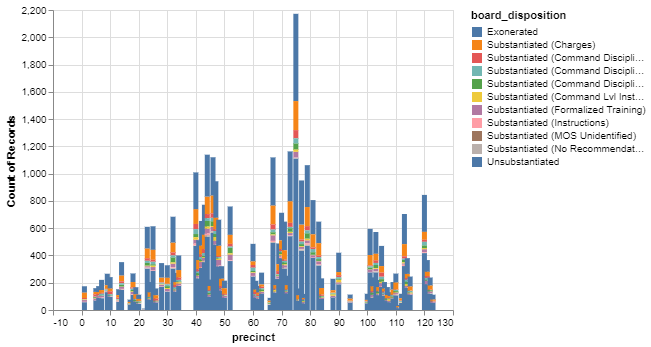

In [16]:
alt.Chart(df.where(df['precinct'] < 300)).mark_bar().encode(
    x = 'precinct',
    y = 'count(precinct):Q',
    color = 'board_disposition'
)

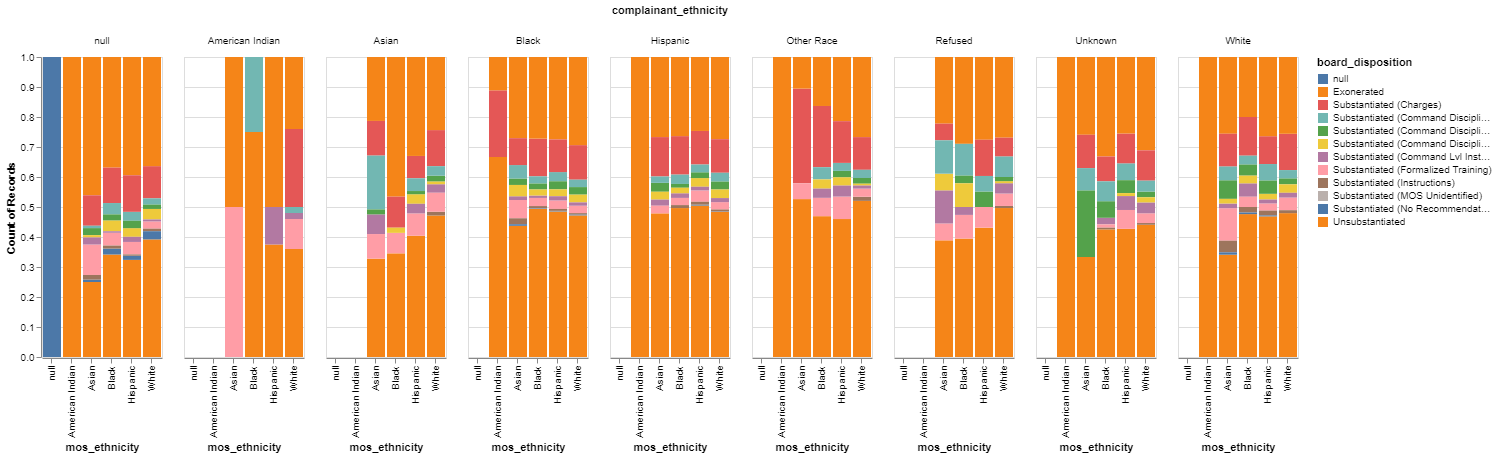

In [17]:
alt.Chart(df.where(df['precinct'] < 300)).mark_bar().encode(
    x = 'mos_ethnicity',
    y = alt.Y('count(mos_ethnicity)',stack = 'normalize'),
    column = 'complainant_ethnicity:N',
    color = 'board_disposition'
)

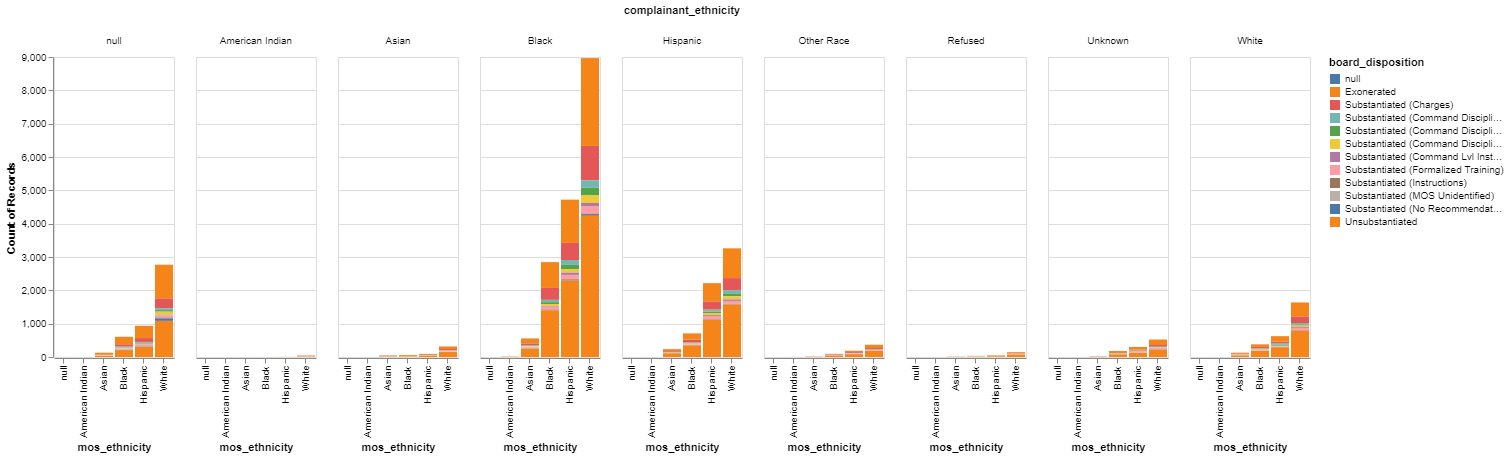

In [18]:
alt.Chart(df.where(df['precinct'] < 300)).mark_bar().encode(
    x = 'mos_ethnicity',
    y = alt.Y('count(mos_ethnicity)'),
    column = 'complainant_ethnicity:N',
    color = 'board_disposition'
)

In [ ]:
# Initialize the map with a restriction on zoom
choroplethPopup = folium.Map([34.055862, -118.326904], max_zoom = 12)

# Make a container for all the geo blocks
zipcodeLayer = folium.FeatureGroup(name = 'Zip Codes')
# We'll want the overlays to be transparent so they don't cover up the choropleth
transparent = {'fillColor': '#00000000', 'color': '#00000000'}

# Create the choropleth based on the total counts within each zip
folium.Choropleth(
    geo_data = cityzipCodes,
    name = 'Choropleth',
    data = counts,
    columns = ['Zip', 'Total'],
    key_on = 'feature.properties.ZIPCODE',
    fill_color = 'BuPu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Total Crimes').add_to(choroplethPopup)

# For every zip code define its geoJson as a separate area attach a popup then put it in the container
for i in zipCodeArray:
    datarow = counts.where(counts['Zip'] == i).dropna().iloc[0]
    gs = folium.GeoJson(zipCodes.loc[zipCodes['ZIPCODE'] == i], style_function = lambda x: transparent)
    zipCodelabel = i
    crimeslabel = datarow['Crime Count']
    arrestslabel = datarow['Arrest Count']
    totallabel = datarow['Total']
    populationlabel = populations.where(populations['Zip'] == i).dropna().iloc[0]['Total Population']
    homeValuelabel = int(homeValue.where(homeValue['Zip'] == i).dropna().iloc[0]['Zhvi'])
    streetlightslabel = datarow['Streetlight Count']
    popuphtml = """
            <html>
                <body>
                    <h1>%s</h1>
                    <p>Number of Crimes Commited: %s</p>
                    <p>Number of Arrests Made: %s</p>
                    <p>Total: %s</p>
                    <p>Median Home Price: %s</p>
                    <p>Population: %s</p>
                    <p>Number of Streetlights: %s</p>
                </body>
            </html>"""%(zipCodelabel, str(crimeslabel), str(arrestslabel), str(totallabel), 
                        str(homeValuelabel), str(populationlabel), str(streetlightslabel))
    folium.Popup(popuphtml,max_width = 250, sticky = True).add_to(gs)
    gs.add_to(zipcodeLayer)
    
# Add the geoJson container then add the layer controller
choroplethPopup.add_child(zipcodeLayer)
folium.LayerControl().add_to(choroplethPopup)